In [2]:
!pip install minisom

# Import necessary libraries
import os
import numpy as np
from minisom import MiniSom
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
from PIL import Image
import cv2

  Preparing metadata (setup.py) ... done
  Created wheel for minisom: filename=MiniSom-2.3.5-py3-none-any.whl size=12031 sha256=a506a19f9bc726e06c815c698d7b207f59732c9df9b9fa40c95fd86032a2a324
  Stored in directory: /root/.cache/pip/wheels/be/33/77/b6bb14008fa79a2dd2b79d565e941d5faa2d7f7526e528345b
Successfully built minisom


In [6]:
base_dir = '/kaggle/input/dataset/DeepFish/Classification/organized'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

In [13]:
def load_images(directory):
    X = []
    y = []
    print(f"\nChecking directory: {directory}")
    
    if not os.path.exists(directory):
        print(f"Directory does not exist: {directory}")
        return np.array([]), np.array([])
    
    class_folders = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]
    print(f"Found {len(class_folders)} class folders: {class_folders}")
    
    if not class_folders:
        print("No class folders found.")
        return np.array([]), np.array([])
    
    for class_folder in class_folders:
        class_path = os.path.join(directory, class_folder)
        for subclass in ['empty', 'valid']:
            subclass_path = os.path.join(class_path, subclass)
            if not os.path.exists(subclass_path):
                print(f"Skipping {subclass_path} - not found")
                continue
            
            images = [f for f in os.listdir(subclass_path) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
            print(f"Found {len(images)} images in {subclass_path}")
            
            label = 0 if subclass == 'empty' else 1
            
            for img_file in images:
                img_path = os.path.join(subclass_path, img_file)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is None:
                    print(f"Failed to load: {img_path}")
                    continue
                img = cv2.resize(img, (64, 64))  # Resize to 64x64
                X.append(img.flatten())  # Flatten to 4096 features
                y.append(label)
    
    X = np.array(X)
    y = np.array(y)
    print(f"Loaded {X.shape[0]} images with shape {X.shape}")
    return X, y

In [14]:
print("Loading training data...")
X_train, y_train = load_images(train_dir)
print("Loading validation data...")
X_val, y_val = load_images(val_dir)
print("Loading test data...")
X_test, y_test = load_images(test_dir)

# Check results
if X_train.size == 0 or X_val.size == 0 or X_test.size == 0:
    print("Error: One or more datasets are empty.")
else:
    print(f"\nTrain: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

Loading training data...

Checking directory: /kaggle/input/dataset/DeepFish/Classification/organized/train
Found 9 class folders: ['9907', '9894', '9898', '9852', '9866', '9908', '9870', '9892', '9862']
Found 582 images in /kaggle/input/dataset/DeepFish/Classification/organized/train/9907/empty
Found 159 images in /kaggle/input/dataset/DeepFish/Classification/organized/train/9907/valid
Found 516 images in /kaggle/input/dataset/DeepFish/Classification/organized/train/9894/empty
Found 98 images in /kaggle/input/dataset/DeepFish/Classification/organized/train/9894/valid
Found 174 images in /kaggle/input/dataset/DeepFish/Classification/organized/train/9898/empty
Found 47 images in /kaggle/input/dataset/DeepFish/Classification/organized/train/9898/valid
Found 99 images in /kaggle/input/dataset/DeepFish/Classification/organized/train/9852/empty
Found 95 images in /kaggle/input/dataset/DeepFish/Classification/organized/train/9852/valid
Found 109 images in /kaggle/input/dataset/DeepFish/Class

In [15]:
X_full = np.vstack((X_train, X_val))
y_full = np.hstack((y_train, y_val))
print(f"Combined train+val: {X_full.shape}, Labels: {y_full.shape}")

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_full)  # Normalize full dataset for SOM
X_test_scaled = scaler.transform(X_test)
print(f"Normalized shapes - Train+Val: {X_scaled.shape}, Test: {X_test_scaled.shape}")

Combined train+val: (3894, 4096), Labels: (3894,)
Normalized shapes - Train+Val: (3894, 4096), Test: (3872, 4096)


In [23]:
som_size = (20, 20)
som = MiniSom(som_size[0], som_size[1], X_scaled.shape[1], sigma=1.0, learning_rate=0.5)
som.random_weights_init(X_scaled)
print("Training SOM...")
som.train_random(X_scaled, 2000)

Training SOM...


In [24]:
print("Extracting SOM features...")
# BMU coordinates (2D)
X_full_bmu = np.array([som.winner(x) for x in X_scaled])  # Shape: (n_samples, 2)
X_test_bmu = np.array([som.winner(x) for x in X_test_scaled])
# Activation responses (400D)
X_full_act = np.array([som.activation_response(x.reshape(1, -1)).flatten() for x in X_scaled])  # Shape: (n_samples, 400)
X_test_act = np.array([som.activation_response(x.reshape(1, -1)).flatten() for x in X_test_scaled])

Extracting SOM features...


In [19]:
print("Training SVM classifiers...")
# SVM with BMU coordinates (2D)
svm_bmu = SVC(kernel='rbf')
svm_bmu.fit(X_full_bmu, y_full)
y_pred_bmu = svm_bmu.predict(X_test_bmu)

svm_act = SVC(kernel='rbf')
svm_act.fit(X_full_act, y_full)
y_pred_act = svm_act.predict(X_test_act)

svm_orig = SVC(kernel='rbf')
svm_orig.fit(X_scaled, y_full)
y_pred_orig = svm_orig.predict(X_test_scaled)


Training SVM classifiers...


In [25]:
accuracy_bmu = accuracy_score(y_test, y_pred_bmu)
accuracy_act = accuracy_score(y_test, y_pred_act)
accuracy_orig = accuracy_score(y_test, y_pred_orig)

In [26]:
results = {
    "Feature Type": ["BMU Coordinates (2D)", "Activation Responses (400D)", "Original Features (4096D)"],
    "SVM Accuracy": [accuracy_bmu, accuracy_act, accuracy_orig]
}
results_df = pd.DataFrame(results)
print("\nPerformance Comparison:")
print(results_df)


Performance Comparison:
                  Feature Type  SVM Accuracy
0         BMU Coordinates (2D)      0.710486
1  Activation Responses (400D)      0.863120
2    Original Features (4096D)      0.868027


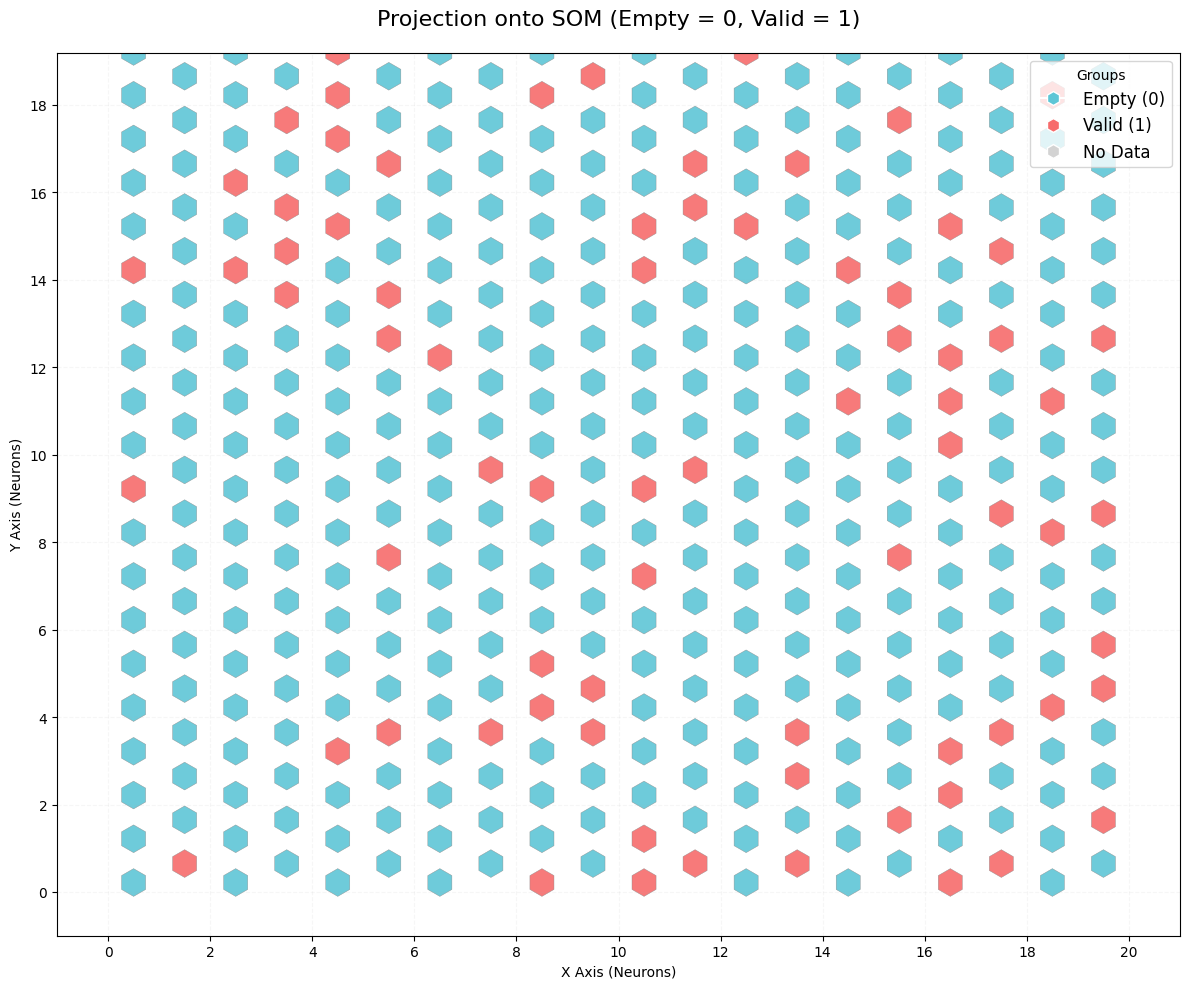

In [32]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

plt.figure(figsize=(12, 10))
plt.title("Projection onto SOM (Empty = 0, Valid = 1)", fontsize=16, pad=20)

# Hexagonal grid coordinates
xx, yy = np.meshgrid(np.arange(20), np.arange(20))
hex_coords = np.array([[x + 0.5, y + 0.5 * np.sqrt(3) * (i % 2 * 0.5 + 0.25)]
                      for i, (x, y) in enumerate(zip(xx.ravel(), yy.ravel()))])

# Hit and class map
hit_map, class_map = np.zeros((20, 20)), np.zeros((20, 20))
for i, x in enumerate(X_scaled):
    w = som.winner(x)
    hit_map[w[1], w[0]] += 1
    class_map[w[1], w[0]] = y_full[i]

# Colors
colors_hex = ['#5EC6D6' if class_map[y, x] == 0 
              else '#F76C6C' if hit_map[y, x] > 0 
              else '#D3D3D3' for y in range(20) for x in range(20)]

plt.scatter(*hex_coords.T, s=400, c=colors_hex, marker='h', alpha=0.9, 
            edgecolors='#888888', linewidth=0.3)

# Customization
plt.xlim(-1, 21)
plt.ylim(-1, 21 * np.sqrt(3) / 2 + 1)
plt.xticks(np.arange(0, 21, 2))
plt.yticks(np.arange(0, 21 * np.sqrt(3) / 2 + 1, 2))
plt.grid(True, linestyle='--', alpha=0.1)
plt.xlabel("X Axis (Neurons)")
plt.ylabel("Y Axis (Neurons)")

# Corrected Legend
legend_elements = [
    Line2D([0], [0], marker='h', color='w', label='Empty (0)', 
           markerfacecolor='#5EC6D6', markersize=10),
    Line2D([0], [0], marker='h', color='w', label='Valid (1)', 
           markerfacecolor='#F76C6C', markersize=10),
    Line2D([0], [0], marker='h', color='w', label='No Data', 
           markerfacecolor='#D3D3D3', markersize=10)
]
plt.legend(handles=legend_elements, loc='upper right', fontsize=12, title='Groups')

plt.tight_layout()
plt.show()


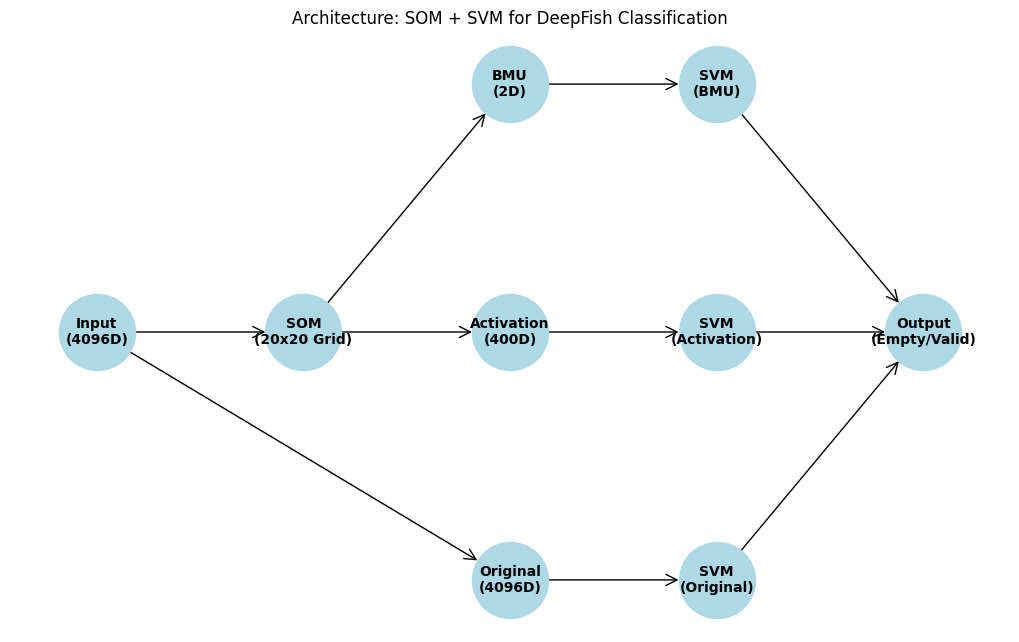

In [33]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph
G = nx.DiGraph()

# Add nodes for each component
G.add_node("Input\n(4096D)", pos=(0, 3))  # Input layer (4096 features)
G.add_node("SOM\n(20x20 Grid)", pos=(2, 3))  # SOM layer (400 neurons)
G.add_node("BMU\n(2D)", pos=(4, 4))  # BMU coordinates output
G.add_node("Activation\n(400D)", pos=(4, 3))  # Activation responses output
G.add_node("Original\n(4096D)", pos=(4, 2))  # Original features (bypass SOM)
G.add_node("SVM\n(BMU)", pos=(6, 4))  # SVM for BMU
G.add_node("SVM\n(Activation)", pos=(6, 3))  # SVM for Activation
G.add_node("SVM\n(Original)", pos=(6, 2))  # SVM for Original
G.add_node("Output\n(Empty/Valid)", pos=(8, 3))  # Final classification

# Add edges to show data flow
G.add_edge("Input\n(4096D)", "SOM\n(20x20 Grid)")  # Input to SOM
G.add_edge("SOM\n(20x20 Grid)", "BMU\n(2D)")  # SOM to BMU
G.add_edge("SOM\n(20x20 Grid)", "Activation\n(400D)")  # SOM to Activation
G.add_edge("Input\n(4096D)", "Original\n(4096D)")  # Input to Original (bypass)
G.add_edge("BMU\n(2D)", "SVM\n(BMU)")  # BMU to SVM
G.add_edge("Activation\n(400D)", "SVM\n(Activation)")  # Activation to SVM
G.add_edge("Original\n(4096D)", "SVM\n(Original)")  # Original to SVM
G.add_edge("SVM\n(BMU)", "Output\n(Empty/Valid)")  # SVM to Output
G.add_edge("SVM\n(Activation)", "Output\n(Empty/Valid)")  # SVM to Output
G.add_edge("SVM\n(Original)", "Output\n(Empty/Valid)")  # SVM to Output

# Get positions for plotting
pos = nx.get_node_attributes(G, 'pos')

# Draw the graph
plt.figure(figsize=(10, 6))
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='lightblue', font_size=10, font_weight='bold', arrows=True, arrowstyle='->', arrowsize=20)
plt.title("Architecture: SOM + SVM for DeepFish Classification")
plt.show()